In [1]:
# Temporal Average 
#  4D fMRI 데이터의 모든 시간점을 평균내어 단일 3D 볼륨

import os
import nibabel as nib
import numpy as np
from nipype.interfaces import fsl

def create_mean_img(in_file, out_file):
    img = nib.load(in_file)
    mean_data = np.mean(img.get_fdata(), axis=3)
    mean_img = nib.Nifti1Image(mean_data, img.affine, img.header)
    nib.save(mean_img, out_file)
    return out_file

def run_bet(in_file, out_file):
    bet = fsl.BET(in_file=in_file, out_file=out_file, frac=0.3)
    return bet.run()

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=12):
    flirt = fsl.FLIRT()
    flirt.inputs.in_file = in_file
    flirt.inputs.reference = ref_file
    flirt.inputs.out_file = out_file
    flirt.inputs.out_matrix_file = out_matrix_file
    flirt.inputs.dof = dof
    flirt.inputs.cost = 'corratio'
    return flirt.run()

def preprocess_fmri(func_file, struct_file, standard_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    mean_func_output = os.path.join(output_dir, "mean_func.nii.gz")
    create_mean_img(func_file, mean_func_output)

    bet_output = os.path.join(output_dir, "bet_output.nii.gz")
    run_bet(mean_func_output, bet_output)

    mni_output = os.path.join(output_dir, "mni_output.nii.gz")
    mni_matrix = os.path.join(output_dir, "mni_matrix.mat")
    run_flirt(bet_output, standard_file, mni_output, mni_matrix, dof=12)

    return mni_output

func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
struct_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/anat2/NIFTI/sub-OAS30011_ses-d0055_T1w.nii.gz"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/TemporalAverage_Sample"

print(f"FSLDIR: {os.environ.get('FSLDIR')}")
print(f"PATH: {os.environ.get('PATH')}")

print(f"Func file exists: {os.path.exists(func_file)}")
print(f"Struct file exists: {os.path.exists(struct_file)}")
print(f"Standard file exists: {os.path.exists(standard_file)}")

final_output = preprocess_fmri(func_file, struct_file, standard_file, output_dir)

preprocessed_data = nib.load(final_output).get_fdata()

print(f"Final output exists: {os.path.exists(final_output)}")
print(f"Original functional data shape: {nib.load(func_file).shape}")
print(f"Preprocessed MNI data shape: {preprocessed_data.shape}")

FSLDIR: /home/minyoungxi/fsl
PATH: /home/minyoungxi/anaconda3/envs/TorchEnv/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/.local/bin:/home/minyoungxi/gems/bin:/home/minyoungxi/anaconda3/envs/TorchEnv/bin:/home/minyoungxi/anaconda3/condabin:/usr/local/cuda/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/fsl/share/fsl/bin:/home/minyoungxi/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin:/usr/bin/obsidian:/usr/bin/obsidian
Func file exists: True
Struct file exists: True
Standard file exists: True
Final output exists: True
Original functional data shape: (64, 64, 36, 164)
Preprocessed MNI data shape: (182, 218, 182)


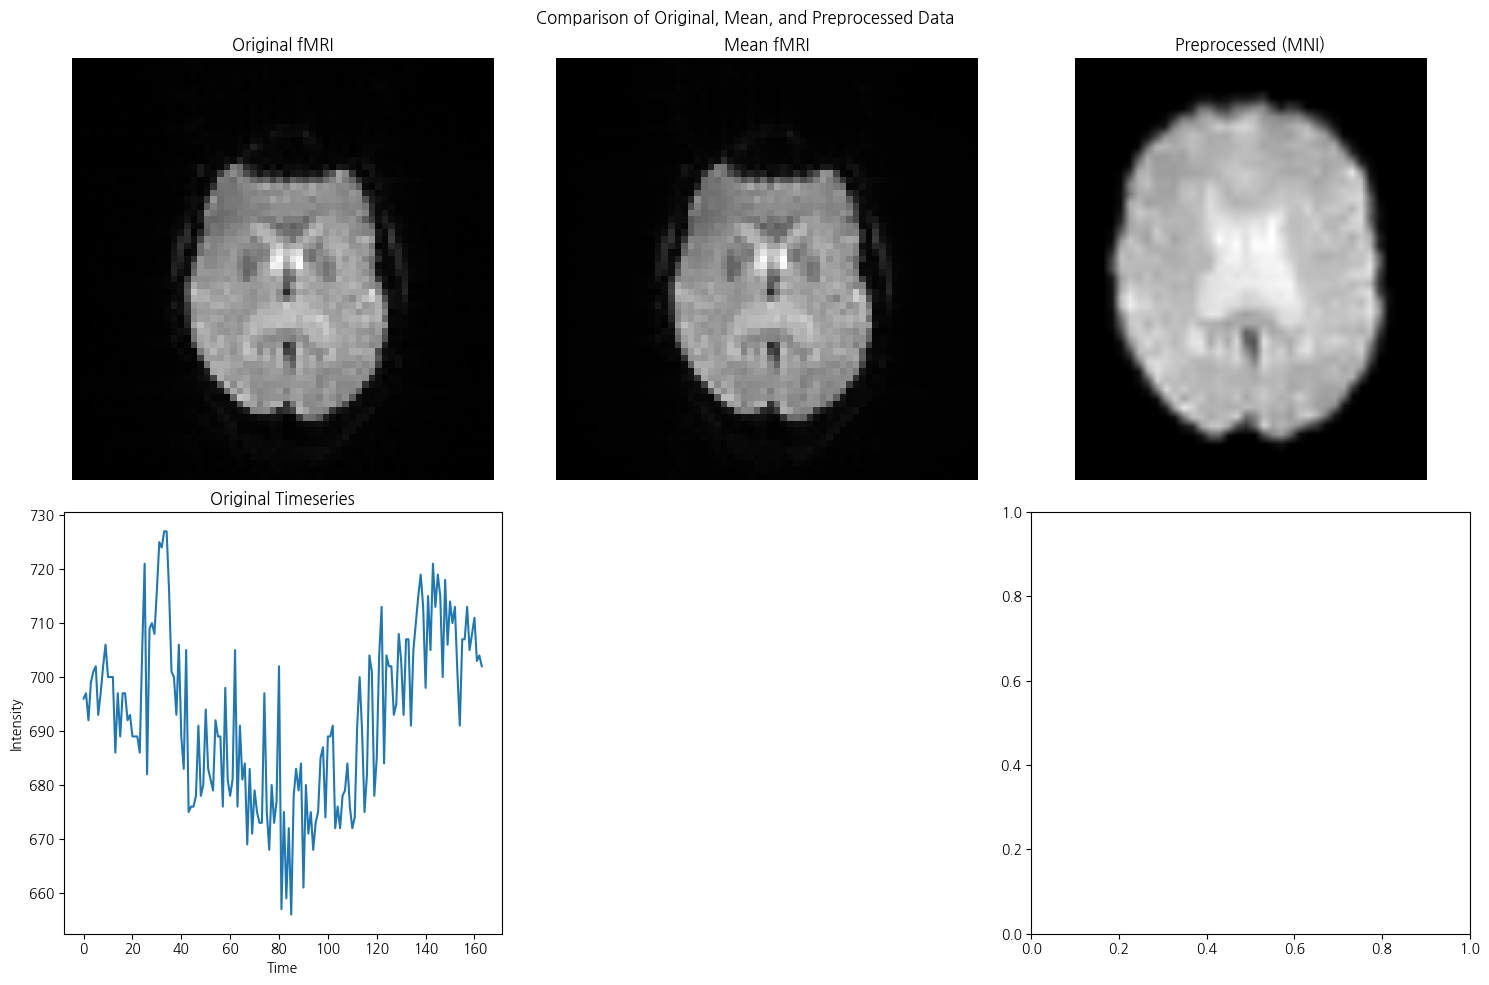

Original functional data shape: (64, 64, 36, 164)
Mean functional data shape: (64, 64, 36)
Preprocessed MNI data shape: (182, 218, 182)
Original functional data range: 0.0 to 1284.0
Mean functional data range: 0.0 to 1077.8658770397305
Preprocessed MNI data range: 0.0 to 1057.7962646484375


In [3]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def plot_slice(ax, data, title):
    if data.ndim == 4:
        mid_time = data.shape[3] // 2
        slice_data = data[:, :, data.shape[2]//2, mid_time]
    else:
        slice_data = data[:, :, data.shape[2]//2]
    ax.imshow(slice_data.T, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.axis('off')

def plot_timeseries(ax, data, title):
    if data.ndim == 4:
        center = tuple(s // 2 for s in data.shape[:3])
        timeseries = data[center[0], center[1], center[2], :]
        ax.plot(timeseries)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Intensity')

orig_func_img = nib.load(func_file)
orig_func_data = orig_func_img.get_fdata()


mean_func_file = os.path.join(output_dir, "mean_func.nii.gz")
mean_func_data = nib.load(mean_func_file).get_fdata()

mni_data = nib.load(final_output).get_fdata()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Comparison of Original, Mean, and Preprocessed Data')

plot_slice(axes[0, 0], orig_func_data, 'Original fMRI')
plot_slice(axes[0, 1], mean_func_data, 'Mean fMRI')
plot_slice(axes[0, 2], mni_data, 'Preprocessed (MNI)')

plot_timeseries(axes[1, 0], orig_func_data, 'Original Timeseries')
axes[1, 1].axis('off')
plot_timeseries(axes[1, 2], mni_data, 'Preprocessed Timeseries')

plt.tight_layout()
plt.show()

print(f"Original functional data shape: {orig_func_data.shape}")
print(f"Mean functional data shape: {mean_func_data.shape}")
print(f"Preprocessed MNI data shape: {mni_data.shape}")

print(f"Original functional data range: {orig_func_data.min()} to {orig_func_data.max()}")
print(f"Mean functional data range: {mean_func_data.min()} to {mean_func_data.max()}")
print(f"Preprocessed MNI data range: {mni_data.min()} to {mni_data.max()}")

# 3D Time pointing

In [10]:
import os
import nibabel as nib
import numpy as np
from nipype.interfaces import fsl
from tqdm import tqdm

def run_bet(in_file, out_file):
    bet = fsl.BET(in_file=in_file, out_file=out_file, frac=0.3)
    return bet.run()

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=12):
    flirt = fsl.FLIRT()
    flirt.inputs.in_file = in_file
    flirt.inputs.reference = ref_file
    flirt.inputs.out_file = out_file
    flirt.inputs.out_matrix_file = out_matrix_file
    flirt.inputs.dof = dof
    flirt.inputs.cost = 'corratio'
    return flirt.run()

def preprocess_fmri_3d_pointing(func_file, standard_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    func_img = nib.load(func_file)
    func_data = func_img.get_fdata()
    num_volumes = func_data.shape[3]

    bet_data = np.zeros_like(func_data)
    mni_data = np.zeros_like(func_data)

    for i in tqdm(range(num_volumes), desc="Processing volumes"):
        volume = func_data[:,:,:,i]
        volume_img = nib.Nifti1Image(volume, func_img.affine)
        volume_file = os.path.join(output_dir, f"volume_{i}.nii.gz")
        nib.save(volume_img, volume_file)

        bet_output = os.path.join(output_dir, f"bet_volume_{i}.nii.gz")
        run_bet(volume_file, bet_output)
        bet_volume = nib.load(bet_output).get_fdata()
        bet_data[:,:,:,i] = bet_volume

        mni_output = os.path.join(output_dir, f"mni_volume_{i}.nii.gz")
        mni_matrix = os.path.join(output_dir, f"mni_matrix_{i}.mat")
        run_flirt(bet_output, standard_file, mni_output, mni_matrix, dof=12)

        resampled_output = os.path.join(output_dir, f"resampled_volume_{i}.nii.gz")
        run_flirt(mni_output, volume_file, resampled_output, os.path.join(output_dir, f"resample_matrix_{i}.mat"), dof=6)

        resampled_volume = nib.load(resampled_output).get_fdata()
        mni_data[:,:,:,i] = resampled_volume

        for file in [volume_file, bet_output, mni_output, resampled_output, mni_matrix]:
            if os.path.exists(file):
                os.remove(file)

    final_bet_output = os.path.join(output_dir, "final_bet_output.nii.gz")
    final_mni_output = os.path.join(output_dir, "final_mni_output.nii.gz")
    
    nib.save(nib.Nifti1Image(bet_data, func_img.affine, func_img.header), final_bet_output)
    nib.save(nib.Nifti1Image(mni_data, func_img.affine, func_img.header), final_mni_output)

    bet_img = nib.load(final_bet_output)
    mni_img = nib.load(final_mni_output)
    
    print(f"BET output shape: {bet_img.shape}")
    print(f"MNI output shape: {mni_img.shape}")

    return final_bet_output, final_mni_output

center_voxel = tuple(s // 2 for s in mni_data.shape[:3])
time_series = mni_data[center_voxel]
print(f"Time series at center voxel: {time_series[:10]}...")  # 처음 10개 시간점만 출력

func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
standard_file = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/3DTimeSample"

final_bet_output, final_mni_output = preprocess_fmri_3d_pointing(func_file, standard_file, output_dir)


print(f"Original functional data shape: {nib.load(func_file).shape}")
print(f"Final BET output shape: {nib.load(final_bet_output).shape}")
print(f"Final MNI output shape: {nib.load(final_mni_output).shape}")

Time series at center voxel: [830.55287397 812.21868292 807.514413   813.55830945 798.68222411
 819.22835664 814.13466041 800.05300475 807.87268521 809.71077743]...


Processing volumes: 100%|██████████| 164/164 [31:04<00:00, 11.37s/it]


BET output shape: (64, 64, 36, 164)
MNI output shape: (64, 64, 36, 164)
Original functional data shape: (64, 64, 36, 164)
Final BET output shape: (64, 64, 36, 164)
Final MNI output shape: (64, 64, 36, 164)


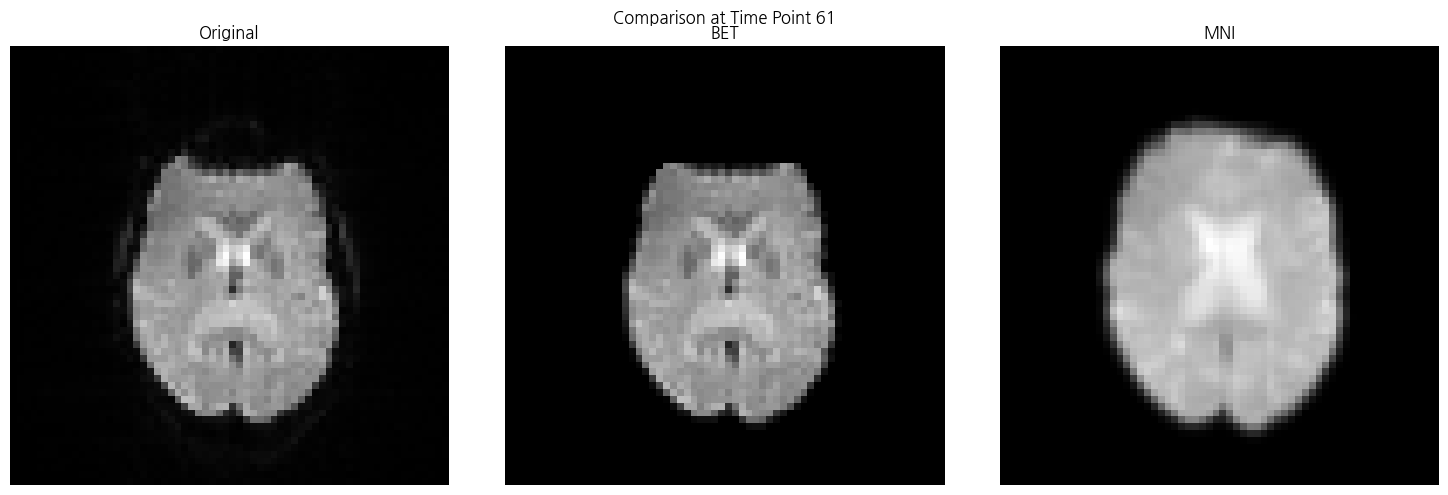

Original data shape: (64, 64, 36, 164)
BET data shape: (64, 64, 36, 164)
MNI data shape: (64, 64, 36, 164)
Randomly selected time point: 61


In [11]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import random

def plot_slice_comparison(orig_data, bet_data, mni_data, time_point, slice_index=None):
    if slice_index is None:
        slice_index = orig_data.shape[2] // 2 

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Comparison at Time Point {time_point}")

    axes[0].imshow(orig_data[:, :, slice_index, time_point].T, cmap='gray', origin='lower')
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(bet_data[:, :, slice_index, time_point].T, cmap='gray', origin='lower')
    axes[1].set_title("BET")
    axes[1].axis('off')

    axes[2].imshow(mni_data[:, :, slice_index, time_point].T, cmap='gray', origin='lower')
    axes[2].set_title("MNI")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


func_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30011_MR_d0055/func2/NIFTI/sub-OAS30011_ses-d0055_task-rest_run-02_bold.nii.gz"
bet_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/3DTimeSample/final_bet_output.nii.gz"
mni_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/3DTimeSample/final_mni_output.nii.gz"

orig_data = nib.load(func_file).get_fdata()
bet_data = nib.load(bet_file).get_fdata()
mni_data = nib.load(mni_file).get_fdata()

time_point = random.randint(0, orig_data.shape[3] - 1)


plot_slice_comparison(orig_data, bet_data, mni_data, time_point)

print(f"Original data shape: {orig_data.shape}")
print(f"BET data shape: {bet_data.shape}")
print(f"MNI data shape: {mni_data.shape}")

print(f"Randomly selected time point: {time_point}")

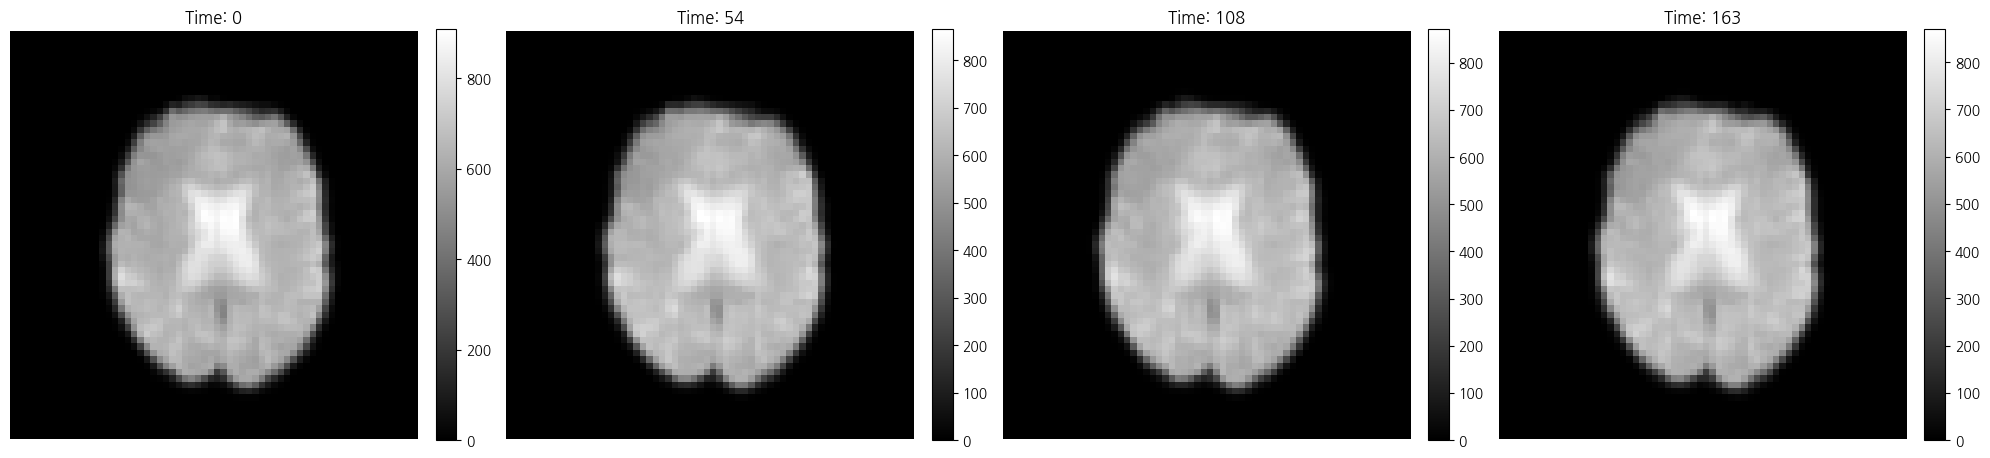

MNI data shape: (64, 64, 36, 164)
MNI data type: float64
MNI data range: 0.0 to 1020.8421499980614


In [12]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def plot_mni_timepoints(mni_file, num_timepoints=4, slice_index=None):
    mni_img = nib.load(mni_file)
    mni_data = mni_img.get_fdata()
    
    if slice_index is None:
        slice_index = mni_data.shape[2] // 2  # 중간 슬라이스

    total_timepoints = mni_data.shape[3]
    selected_timepoints = np.linspace(0, total_timepoints-1, num_timepoints, dtype=int)

    fig, axes = plt.subplots(1, num_timepoints, figsize=(5*num_timepoints, 5))
    if num_timepoints == 1:
        axes = [axes]

    for i, tp in enumerate(selected_timepoints):
        ax = axes[i]
        slice_data = mni_data[:, :, slice_index, tp]
        im = ax.imshow(slice_data.T, cmap='gray', origin='lower')
        ax.set_title(f'Time: {tp}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print(f"MNI data shape: {mni_data.shape}")
    print(f"MNI data type: {mni_data.dtype}")
    print(f"MNI data range: {np.min(mni_data)} to {np.max(mni_data)}")

mni_file = "/home/minyoungxi/MINYOUNGXI/XFL/Data/preprocessed/3DTimeSample/final_mni_output.nii.gz"

plot_mni_timepoints(mni_file, num_timepoints=4)